In [2]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import random
import time
import matplotlib.pyplot as plt
import sys

In [3]:
# Parameters for MC simulation of stock prices

S0 = 100      # initial stock price
mu = 0.05     # drift
sigma = 0.15  # volatility
r = 0.03      # risk-free rate
M = 1         # maturity

T = 24        # number of time steps
N_MC = 10000  # number of paths

delta_t = M / T                # time interval
gamma = np.exp(- r * delta_t)  # discount factor

# Black-Sholes Simulation
Simulate  𝑁𝑀𝐶  stock price sample paths with  𝑇  steps by the classical Black-Sholes formula.

𝑑𝑆𝑡=𝜇𝑆𝑡𝑑𝑡+𝜎𝑆𝑡𝑑𝑊𝑡𝑆𝑡+1=𝑆𝑡𝑒(𝜇−12𝜎2)Δ𝑡+𝜎Δ𝑡√𝑍
 
where  𝑍  is a standard normal random variable.

Based on simulated stock price  𝑆𝑡  paths, compute state variable  𝑋𝑡  by the following relation.

𝑋𝑡=−(𝜇−12𝜎2)𝑡Δ𝑡+log𝑆𝑡
 
Also compute

Δ𝑆𝑡=𝑆𝑡+1−𝑒𝑟Δ𝑡𝑆𝑡Δ𝑆̂ 𝑡=Δ𝑆𝑡−Δ𝑆¯𝑡𝑡=0,...,𝑇−1
 
where  Δ𝑆¯𝑡  is the sample mean of all values of  Δ𝑆𝑡 .

Plots of 5 stock price  𝑆𝑡  and state variable  𝑋𝑡  paths are shown below.


In [4]:
# make a dataset
starttime = time.time()
np.random.seed(42)

# stock price
S = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
S.loc[:,0] = S0

# standard normal random numbers
RN = pd.DataFrame(np.random.randn(N_MC,T), index=range(1, N_MC+1), columns=range(1, T+1))

for t in range(1, T+1):
    S.loc[:,t] = S.loc[:,t-1] * np.exp((mu - 1/2 * sigma**2) * delta_t + sigma * np.sqrt(delta_t) * RN.loc[:,t])

delta_S = S.loc[:,1:T].values - np.exp(r * delta_t) * S.loc[:,0:T-1]
delta_S_hat = delta_S.apply(lambda x: x - np.mean(x), axis=0)

# state variable
X = - (mu - 1/2 * sigma**2) * np.arange(T+1) * delta_t + np.log(S)   # delta_t here is due to their conventions

endtime = time.time()
print('\nTime Cost:', endtime - starttime, 'seconds')


Time Cost: 0.14730072021484375 seconds


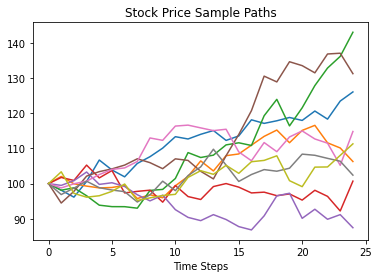

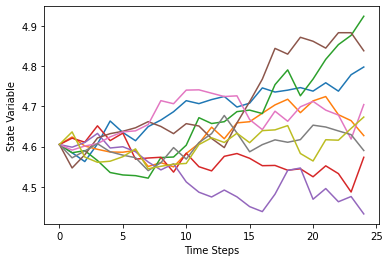

In [5]:
# plot 10 paths
step_size = N_MC // 10
idx_plot = np.arange(step_size, N_MC, step_size)

plt.plot(S.T.iloc[:,idx_plot])
plt.xlabel('Time Steps')
plt.title('Stock Price Sample Paths')
plt.show()

plt.plot(X.T.iloc[:,idx_plot])
plt.xlabel('Time Steps')
plt.ylabel('State Variable')
plt.show()

# Define function terminal_payoff to compute the terminal payoff of a European put option.

𝐻𝑇(𝑆𝑇)=max(𝐾−𝑆𝑇,0)

In [6]:
def terminal_payoff(ST, K):
    # ST   final stock price
    # K    strike
    payoff = max(K - ST, 0)
    return payoff

In [7]:
type(delta_S)

pandas.core.frame.DataFrame

X.shape =  (10000, 25)
X_min, X_max =  4.024923524903037 5.190802775129617
Number of points k =  17


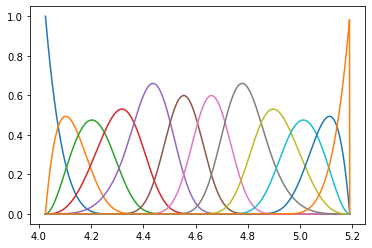

<Figure size 432x288 with 0 Axes>

In [9]:
#Define spline basis function

import bspline
import bspline.splinelab as splinelab

X_min = np.min(np.min(X))
X_max = np.max(np.max(X))
print('X.shape = ', X.shape)
print('X_min, X_max = ', X_min, X_max)

p = 4              # order of spline (as-is; 3 = cubic, 4: B-spline?)
ncolloc = 12

tau = np.linspace(X_min,X_max,ncolloc)  # These are the sites to which we would like to interpolate

# k is a knot vector that adds endpoints repeats as appropriate for a spline of order p
# To get meaninful results, one should have ncolloc >= p+1
k = splinelab.aptknt(tau, p) 
                             
# Spline basis of order p on knots k
basis = bspline.Bspline(k, p)        
        
f = plt.figure()
# B   = bspline.Bspline(k, p)     # Spline basis functions 
print('Number of points k = ', len(k))
basis.plot()

plt.savefig('Basis_functions.png', dpi=600)

In [10]:
type(basis)

bspline.bspline.Bspline

In [11]:
X.values.shape

(10000, 25)

# Make data matrices with feature values
"Features" here are the values of basis functions at data points The outputs are 3D arrays of dimensions num_tSteps x num_MC x num_basis

In [12]:
num_t_steps = T + 1
num_basis =  ncolloc # len(k) #

data_mat_t = np.zeros((num_t_steps, N_MC,num_basis ))
print('num_basis = ', num_basis)
print('dim data_mat_t = ', data_mat_t.shape)

t_0 = time.time()
# fill it 
for i in np.arange(num_t_steps):
    x = X.values[:,i]
    data_mat_t[i,:,:] = np.array([ basis(el) for el in x ])

t_end = time.time()
print('Computational time:', t_end - t_0, 'seconds')

num_basis =  12
dim data_mat_t =  (25, 10000, 12)
Computational time: 28.625903367996216 seconds


In [13]:
# save these data matrices for future re-use
np.save('data_mat_m=r_A_%d' % N_MC, data_mat_t)

In [14]:
print(data_mat_t.shape)  # shape num_steps x N_MC x num_basis
print(len(k))

(25, 10000, 12)
17


# Dynamic Programming solution for QLBS
The MDP problem in this case is to solve the following Bellman optimality equation for the action-value function.

𝑄⋆𝑡(𝑥,𝑎)=𝔼𝑡[𝑅𝑡(𝑋𝑡,𝑎𝑡,𝑋𝑡+1)+𝛾max𝑎𝑡+1∈𝑄⋆𝑡+1(𝑋𝑡+1,𝑎𝑡+1) | 𝑋𝑡=𝑥,𝑎𝑡=𝑎],  𝑡=0,...,𝑇−1,𝛾=𝑒−𝑟Δ𝑡
 
where  𝑅𝑡(𝑋𝑡,𝑎𝑡,𝑋𝑡+1)  is the one-step time-dependent random reward and  𝑎𝑡(𝑋𝑡)  is the action (hedge).

Detailed steps of solving this equation by Dynamic Programming are illustrated below.

# With this set of basis functions {Φ𝑛(𝑋𝑘𝑡)}𝑁𝑛=1, expand the optimal action (hedge) 𝑎⋆𝑡(𝑋𝑡) and optimal Q-function 𝑄⋆𝑡(𝑋𝑡,𝑎⋆𝑡) in basis functions with time-dependent coefficients.
𝑎⋆𝑡(𝑋𝑡)=∑𝑛𝑁𝜙𝑛𝑡Φ𝑛(𝑋𝑡)𝑄⋆𝑡(𝑋𝑡,𝑎⋆𝑡)=∑𝑛𝑁𝜔𝑛𝑡Φ𝑛(𝑋𝑡)
Coefficients 𝜙𝑛𝑡 and 𝜔𝑛𝑡 are computed recursively backward in time for 𝑡=𝑇−1,...,0.

Coefficients for expansions of the optimal action  𝑎⋆𝑡(𝑋𝑡)  are solved by

𝜙𝑡=𝐀−1𝑡𝐁𝑡
 
where  𝐀𝑡  and  𝐁𝑡  are matrix and vector respectively with elements given by

𝐴(𝑡)𝑛𝑚=∑𝑘=1𝑁𝑀𝐶Φ𝑛(𝑋𝑘𝑡)Φ𝑚(𝑋𝑘𝑡)(Δ𝑆̂ 𝑘𝑡)2𝐵(𝑡)𝑛=∑𝑘=1𝑁𝑀𝐶Φ𝑛(𝑋𝑘𝑡)[Π̂ 𝑘𝑡+1Δ𝑆̂ 𝑘𝑡+12𝛾𝜆Δ𝑆𝑘𝑡]
 
Δ𝑆𝑡=𝑆𝑡+1−𝑒−𝑟Δ𝑡𝑆𝑡 𝑡=𝑇−1,...,0
 
where  Δ𝑆̂ 𝑡  is the sample mean of all values of  Δ𝑆𝑡 .

Define function function_A and function_B to compute the value of matrix  𝐀𝑡  and vector  𝐁𝑡 .

In [15]:
risk_lambda = 0.001 # risk aversion
K = 100             # option stike  

# Note that we set coef=0 below in function function_B_vec. This correspond to a pure risk-based hedging

# Part 1 Calculate coefficients  𝜙𝑛𝑡  of the optimal action  𝑎⋆𝑡(𝑋𝑡) 
Instructions:

implement function_A_vec() which computes  𝐴(𝑡)𝑛𝑚  matrix
implement function_B_vec() which computes  𝐵(𝑡)𝑛  column vector


In [16]:
# functions to compute optimal hedges
def function_A_vec(t, delta_S_hat, data_mat, reg_param):
    """
    function_A_vec - compute the matrix A_{nm} from Eq. (52) (with a regularization!)
    Eq. (52) in QLBS Q-Learner in the Black-Scholes-Merton article
    
    Arguments:
    t - time index, a scalar, an index into time axis of data_mat
    delta_S_hat - pandas.DataFrame of dimension N_MC x T
    data_mat - pandas.DataFrame of dimension T x N_MC x num_basis
    reg_param - a scalar, regularization parameter
    
    Return:
    - np.array, i.e. matrix A_{nm} of dimension num_basis x num_basis
    """
    
    X_mat = data_mat[t, :, :]
    num_basis_funcs = X_mat.shape[1]
    this_dS = delta_S_hat.loc[:, t]
    hat_dS2 = (this_dS ** 2).reshape(-1, 1)
    A_mat = np.dot(X_mat.T, X_mat * hat_dS2) + reg_param * np.eye(num_basis_funcs)
    
    
    ### END CODE HERE ###
    return A_mat
   
        
def function_B_vec(t, 
                   Pi_hat, 
                   delta_S_hat=delta_S_hat, 
                   S=S, 
                   data_mat=data_mat_t,
                   gamma=gamma,
                   risk_lambda=risk_lambda):
    """
    function_B_vec - compute vector B_{n} from Eq. (52) QLBS Q-Learner in the Black-Scholes-Merton article
    
    Arguments:
    t - time index, a scalar, an index into time axis of delta_S_hat
    Pi_hat - pandas.DataFrame of dimension N_MC x T of portfolio values 
    delta_S_hat - pandas.DataFrame of dimension N_MC x T
    S - pandas.DataFrame of simulated stock prices of dimension N_MC x T
    data_mat - pandas.DataFrame of dimension T x N_MC x num_basis
    gamma - one time-step discount factor $exp(-r \delta t)$
    risk_lambda - risk aversion coefficient, a small positive number
    Return:
    np.array() of dimension num_basis x 1
    """
    # coef = 1.0/(2 * gamma * risk_lambda)
    # override it by zero to have pure risk hedge
    
    tmp = Pi_hat.loc[:,t+1] * delta_S_hat.loc[:, t]
    X_mat = data_mat[t, :, :]  # matrix of dimension N_MC x num_basis
    B_vec = np.dot(X_mat.T, tmp)
    # store result in B_vec for grading
    
    ### END CODE HERE ###
    return B_vec

In [19]:
reg_param = 1e-3
np.random.seed(42)




In [20]:
np.random.seed(42)
risk_lambda = 0.001
Pi = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
Pi.iloc[:,-1] = S.iloc[:,-1].apply(lambda x: terminal_payoff(x, K))

Pi_hat = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
Pi_hat.iloc[:,-1] = Pi.iloc[:,-1] - np.mean(Pi.iloc[:,-1])
B_vec = function_B_vec(T-1, Pi_hat, delta_S_hat, S, data_mat_t, gamma, risk_lambda)